In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt

plt.style.use("default")
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Liberation Sans"]
plt.rcParams["font.cursive"] = ["Liberation Sans"]
plt.rcParams["mathtext.fontset"] = "custom"

In [3]:
import json
import numpy as np
import pandas as pd
from update_coords import get_sheet

with open("secrets-applications.json", "r") as f:
    secrets = json.load(f)

values = get_sheet(secrets)
df = pd.DataFrame(data=values[1:], columns=values[0])
df = df[df["Veto"] != "Yes"]
len(df)

143

In [4]:
import pytz
from datetime import datetime, timezone

date = datetime(2020, 9, 8)
offsets = []
for _, row in df.iterrows():
    tz = pytz.timezone(row["Time zone"])
    offset = tz.utcoffset(date).seconds / 60 / 60
    if offset > 12:
        offset -= 24
    offsets.append(offset)

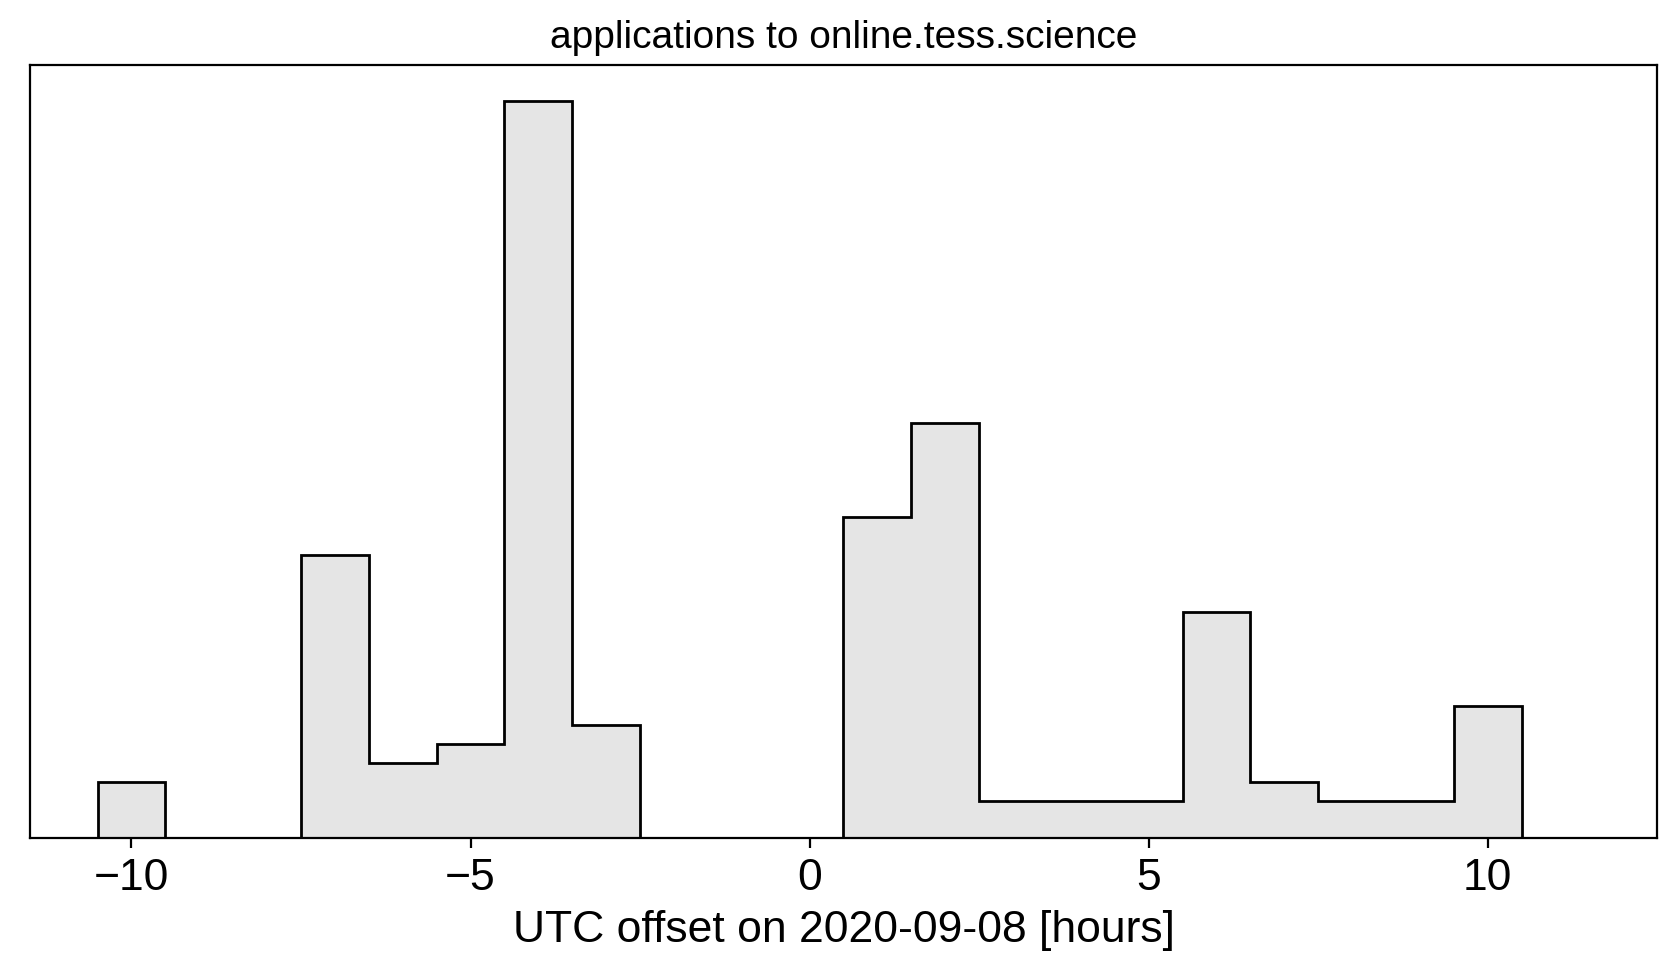

In [5]:
plt.figure(figsize=(1.5 * 7, 1.5 * 3.35))
plt.hist(offsets, np.arange(-11.5, 12 + 1.5, 1), histtype="stepfilled", color="k", alpha=0.1)
plt.hist(offsets, np.arange(-11.5, 12 + 1.5, 1), histtype="step", color="k", lw=1)
plt.xlim(-11.5, 12.5)
plt.yticks([])
plt.xlabel("UTC offset on 2020-09-08 [hours]")
plt.title("applications to online.tess.science", fontsize=14)
plt.savefig("tz-application.png", bbox_inches="tight", dpi=300);

In [6]:
def get_timestamp(tz, time):
    date = datetime.strptime("2020-09-08 " + time, "%Y-%m-%d %I:%M:%S %p")
    return (tz.localize(date).timestamp() - datetime(2020, 9, 8, 8, tzinfo=timezone.utc).timestamp()) / 60 / 60

starts = []
ends = []
for i, (_, row) in enumerate(df.iterrows()):
    tz = pytz.timezone(row["Time zone"])
    start = get_timestamp(tz, row["What time would you like your days to start?"])
    end = get_timestamp(tz, row["What time would you like your days to end?"])
    if end < start:
        end += 24
    if end > 24:
        end -= 24
        start -= 24
    starts.append(start)
    ends.append(end)
    
df["Start timestamp"] = starts
df["End timestamp"] = ends
df["Folded"] = np.array(starts) % 24

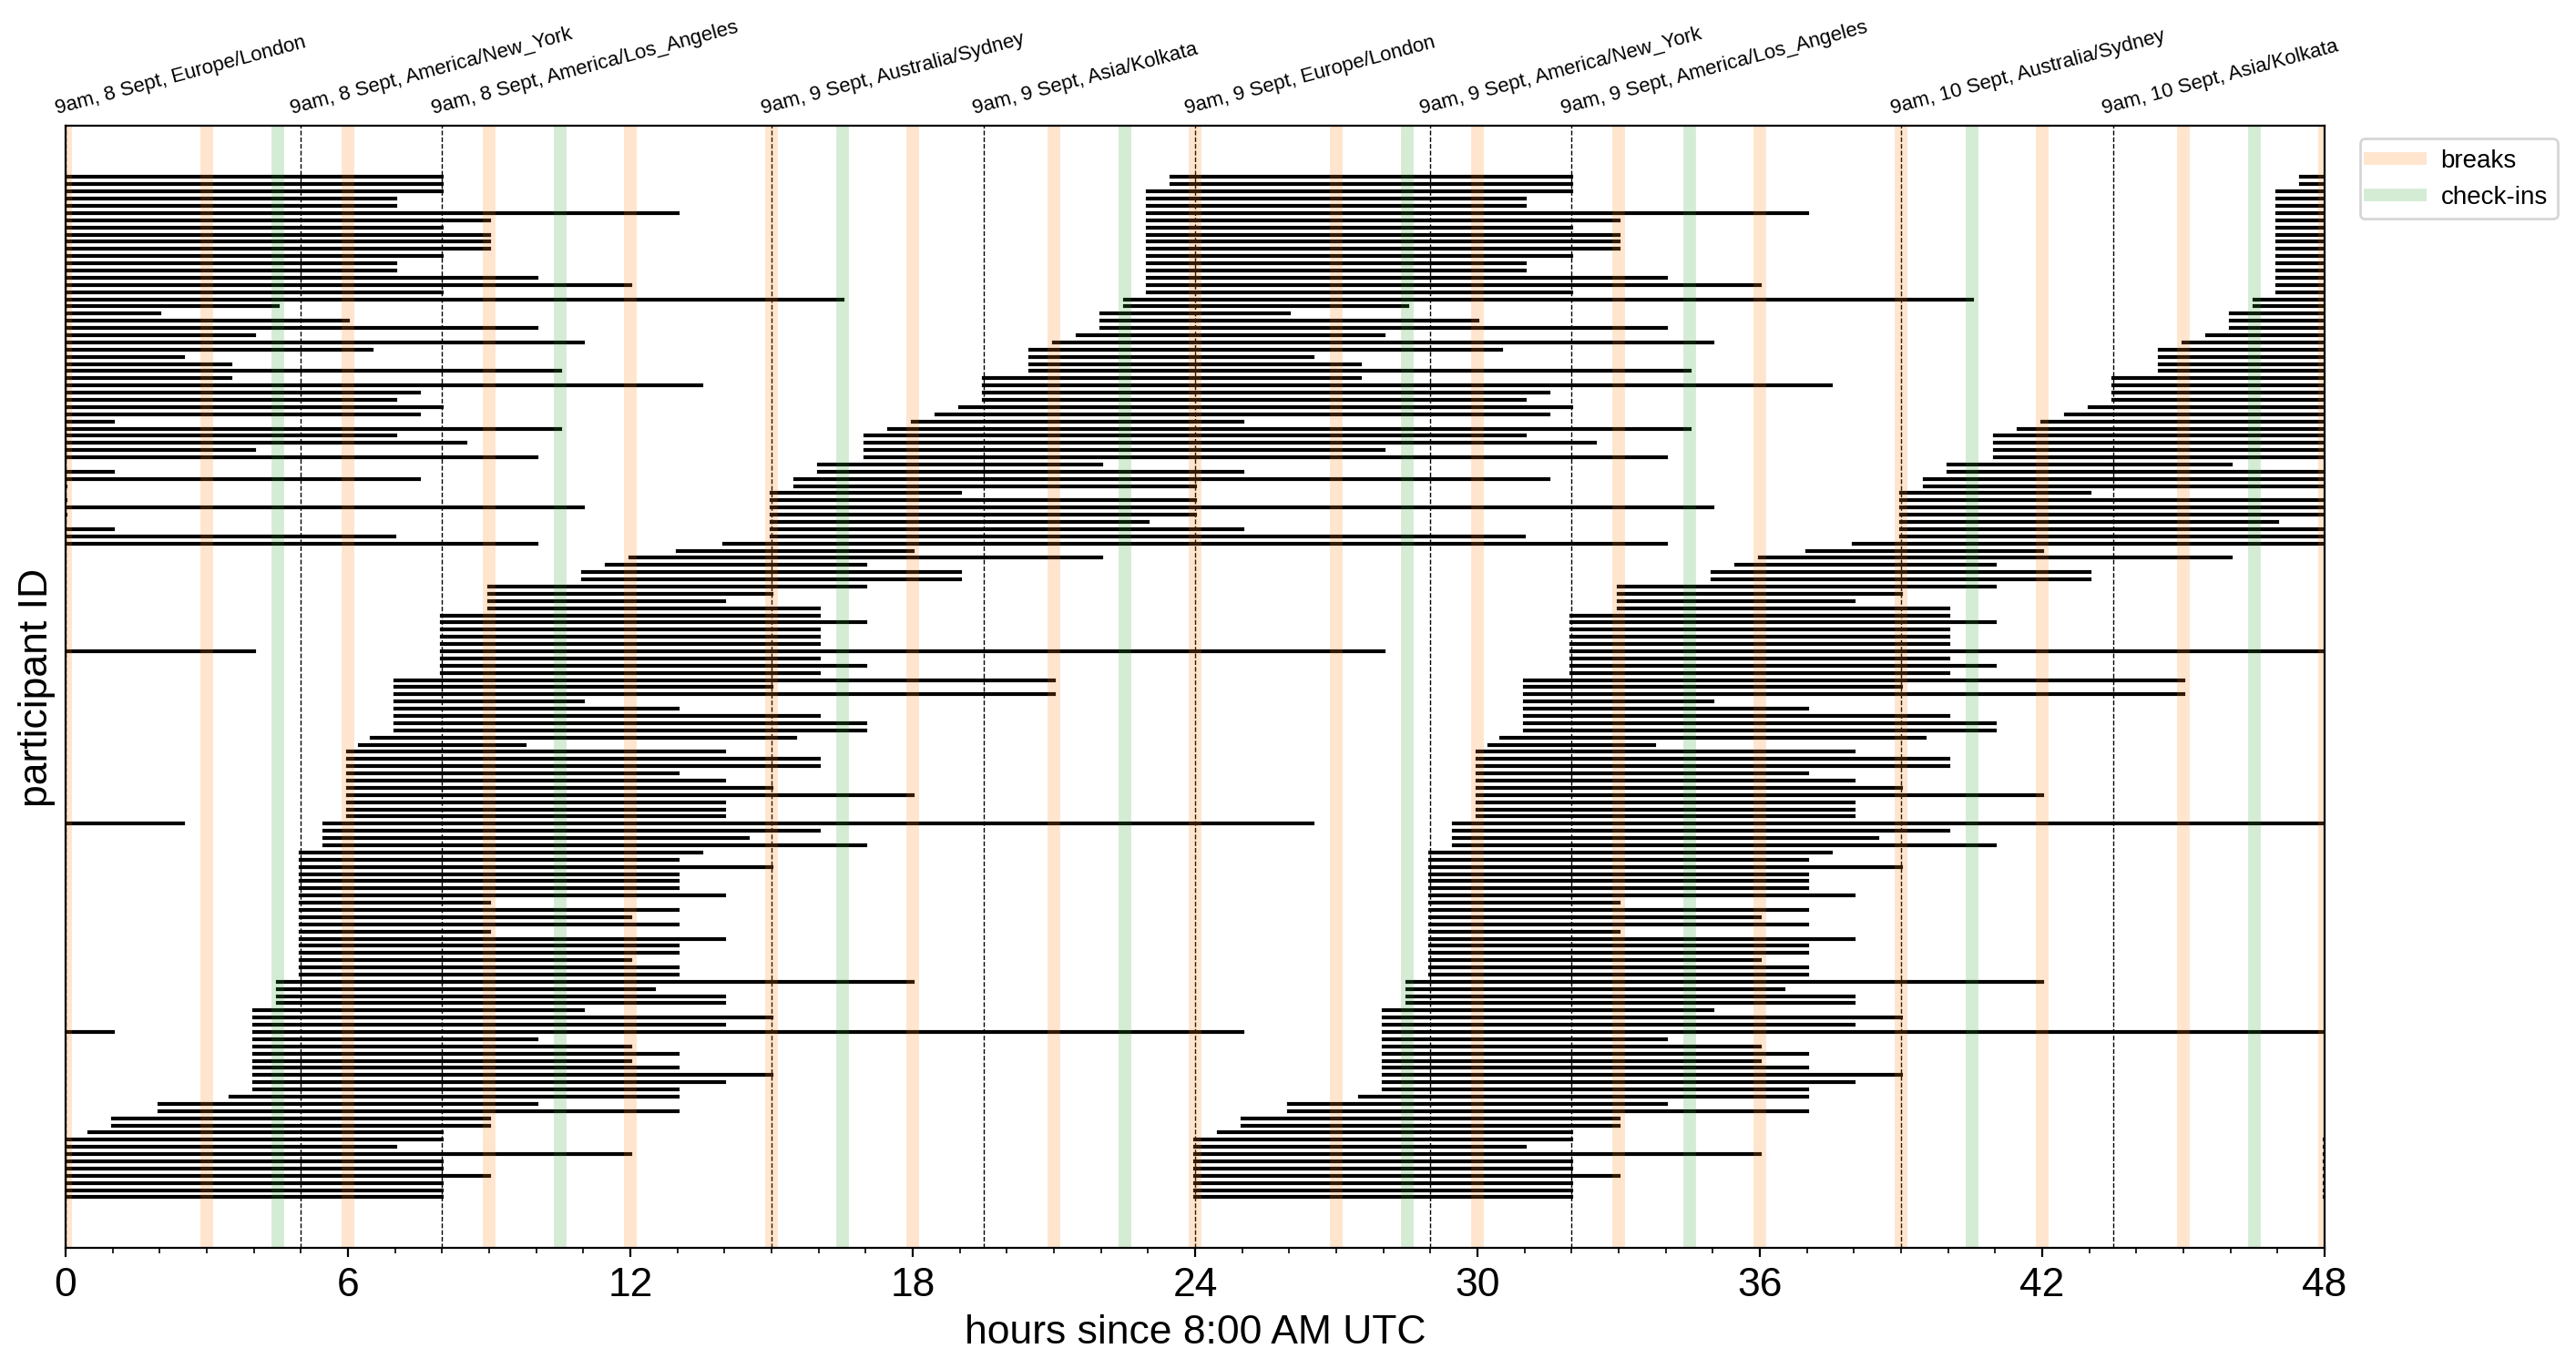

In [7]:
def plot_ref(maxtime):
    for tz in [
        "America/New_York",
        "Europe/London",
        "America/Los_Angeles",
        "Asia/Kolkata",
        "Australia/Sydney",
    ]:
        i = 0
        t = get_timestamp(pytz.timezone(tz), "9:00:00 AM")
        while t < maxtime:
            if t < 0:
                i += 1
                t += 24
                continue
            plt.axvline(t, color="k", linewidth=0.5, ls="dashed")
            plt.annotate(f"9am, {8 + i} Sept, {tz}", (t, plt.ylim()[1]), xycoords="data", fontsize=8, rotation=15,
                         xytext=(-5, 5), textcoords="offset points")

            i += 1
            t += 24

organizers = [
    "Benjamin Montet",
    "Daniel Foreman-Mackey",
    "Guy Davies",
    "Christina Hedges",
]
            
plt.figure(figsize=(16, 8))
for i, (_, row) in enumerate(df.sort_values("Folded").iterrows()):
    start = row["Start timestamp"]
    end = row["End timestamp"]
    
#     if row["First (given) names"] + " " + row["Last (family) name"] in organizers:
#         handle1, = plt.plot([start, end], [i, i], color="C9", lw=5, alpha=0.5, label="organizers")
#         plt.plot([start + 24, end + 24], [i, i], color="C9", lw=5, alpha=0.5)
#         plt.plot([start + 48, end + 48], [i, i], color="C9", lw=5, alpha=0.5)
    
#     plt.plot([start, end], [i, i], color="C{0}".format(i % 9))
#     plt.plot([start + 24, end + 24], [i, i], color="C{0}".format(i % 9))
#     plt.plot([start + 48, end + 48], [i, i], color="C{0}".format(i % 9))
    plt.plot([start, end], [i, i], color="k")
    plt.plot([start + 24, end + 24], [i, i], color="k")
    plt.plot([start + 48, end + 48], [i, i], color="k")
    
plt.xlim(0, 48)
plt.yticks([])
# plt.xticks([0, 6, 12, 24, 36, 48])
plt.xticks(np.arange(0, 49, 6))
plt.minorticks_on()
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
plt.xlabel("hours since 8:00 AM UTC")
plt.ylabel("participant ID")

plot_ref(48)

# Plot coffee breaks
for i in range(0, 49, 3):
    handle2 = plt.axvline(i, color="C1", lw=5, alpha=0.2, label="breaks")

for i in np.arange(4.5, 49, 6):
    handle3 = plt.axvline(i, color="C2", lw=5, alpha=0.2, label="check-ins")
        
plt.legend(handles=[handle2, handle3], fontsize=10, bbox_to_anchor=(1.01, 1), loc='upper left')
    
plt.savefig("barplot.png", bbox_inches="tight", dpi=300);

26 Facilitators


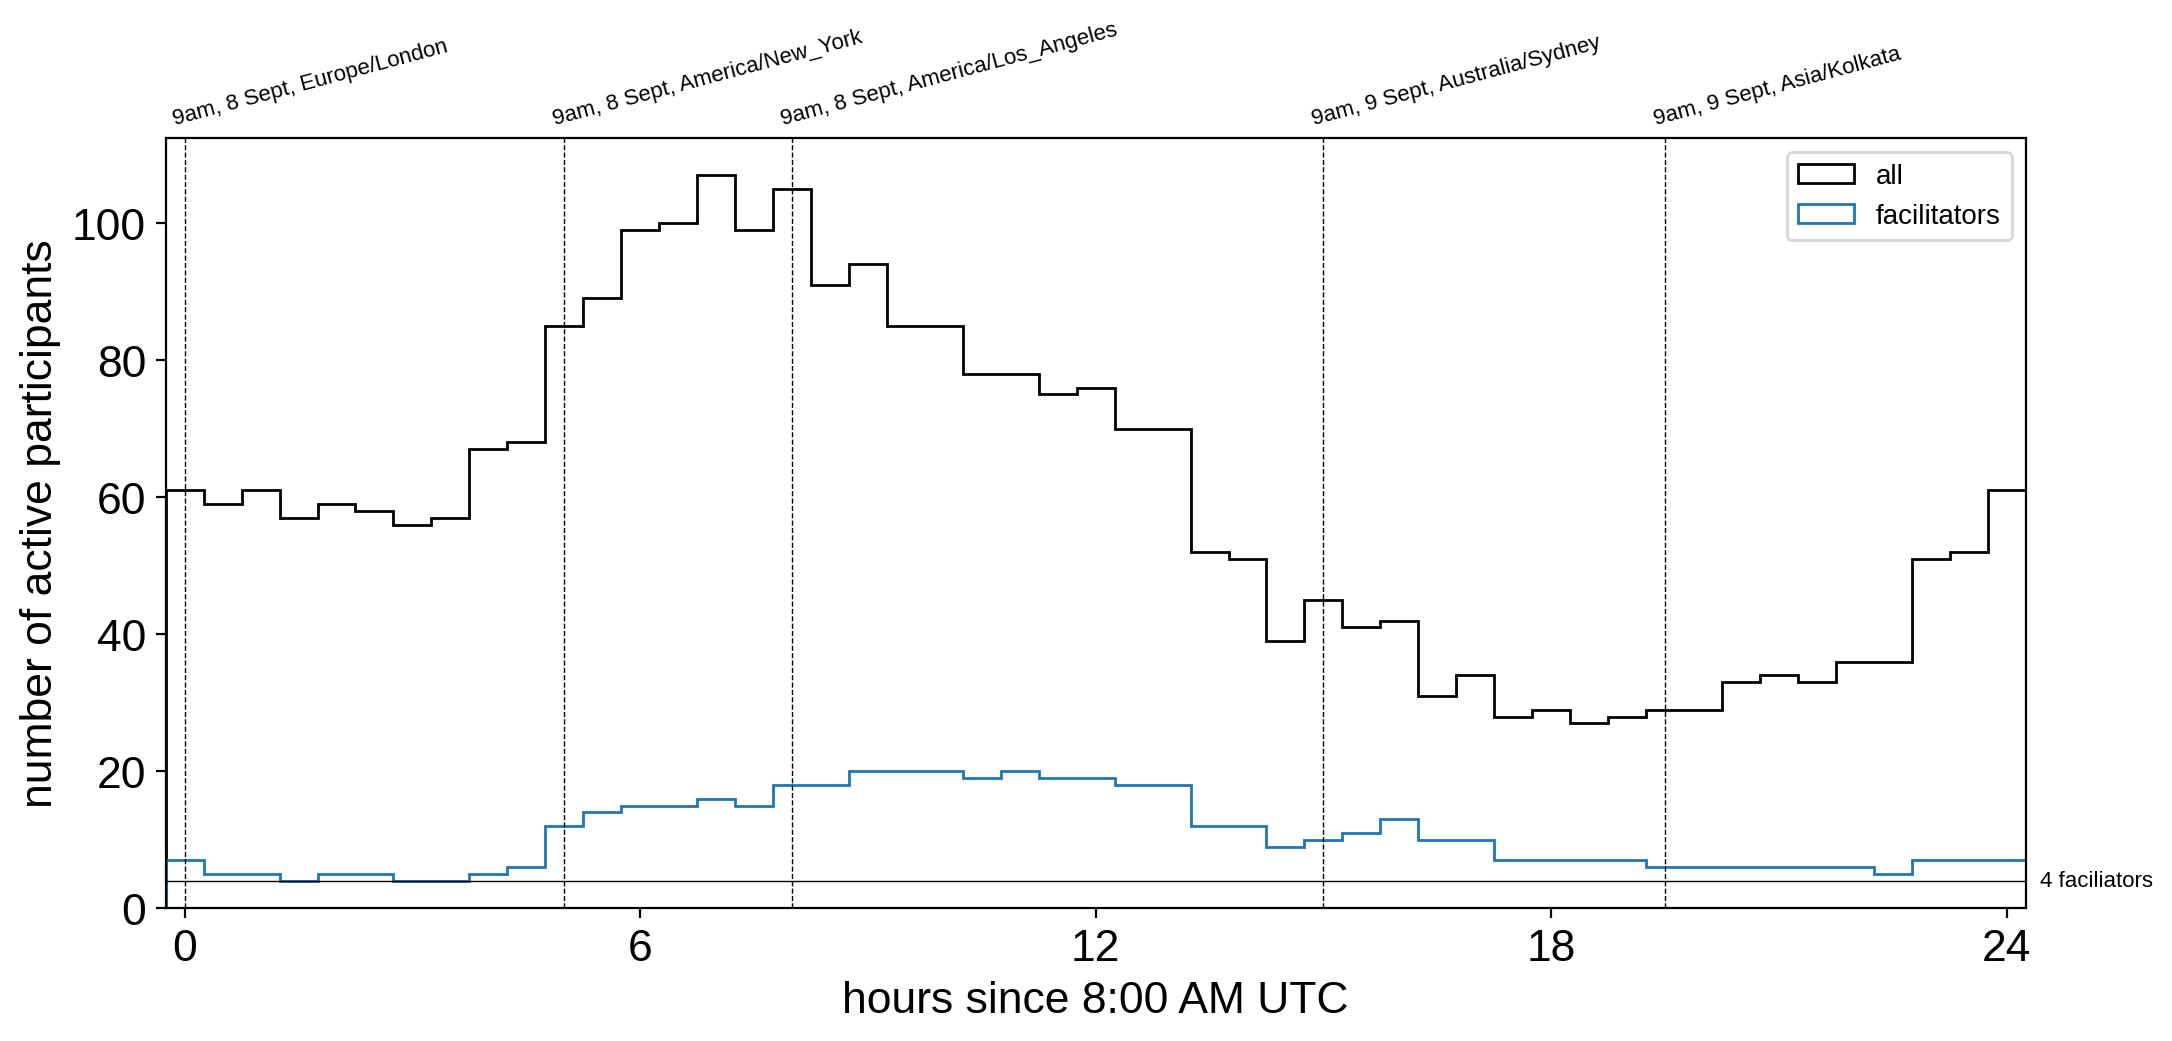

In [8]:
plt.figure(figsize=(12, 5))

nfac = 0
counts = []
fac = []
for i, (_, row) in enumerate(df.sort_values("Folded").iterrows()):
    start = row["Start timestamp"]
    end = row["End timestamp"]
    counts.append(np.arange(start, end + 0.5, 0.5))
    counts.append(np.arange(24 + start, 24 + end + 0.5, 0.5))
    
    flag = row["Have you attended a previous tess.science (or tess.ninja) workshop?"].startswith("No")
    flag |= row["Would you be interested in acting as a facilitator?"] == "No"
    if flag:
        continue

    nfac += 1
    fac.append(np.arange(start, end + 0.5, 0.5))
    fac.append(np.arange(24 + start, 24 + end + 0.5, 0.5))

print(f"{nfac} Facilitators")
    
counts = np.concatenate(counts)
fac = np.concatenate(fac)

plt.hist(counts, np.arange(-0.25, 25.5, 0.5), histtype="step", color="k", label="all")
plt.hist(fac, np.arange(-0.25, 25.5, 0.5), histtype="step", color="C0", label="facilitators")
plt.legend(fontsize=10)
plt.xlim(-0.25, 24.25)
plt.xticks([0, 6, 12, 18, 24])

plt.axhline(4, color="k", lw=0.5)
plt.annotate("4 faciliators", (24.25, 4), xycoords="data", fontsize=8, va="center",
             xytext=(5, 0), textcoords="offset points")

plt.xlabel("hours since 8:00 AM UTC")
plt.ylabel("number of active participants")

plot_ref(24)
plt.savefig("active.png", bbox_inches="tight", dpi=300);